# Evaluating CGNet

Purpose:
--------
The purpose of this notebook is to evaluate CGnet for machine learning detection of atmospheric rivers and tropical cyclones.\
See ClimateNet repo here: https://github.com/andregraubner/ClimateNet

Authors/Contributors:
---------------------
* Katie Dagon

## Import libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import glob

## Set evaluation filepaths

In [2]:
cgnet_test_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new/test/" # testing data (labels and underlying data)

In [3]:
cgnet_eval_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/evaluate/" # trained model applied to test data

## Read in labels
Separately from underlying data due to concatenation issues

In [4]:
test_files = sorted(glob.glob(cgnet_test_filepath+"*.nc"))
test_files
len(test_files)

61

Use preprocess function to add a `sample` dim with time information as the coordinate

In [5]:
def preprocess_samps(ds):
    ds['LABELS'] = ds.LABELS.expand_dims(dim={"sample": ds.time.values})
    return ds['LABELS']

In [10]:
%%time
cgnet_test_labels = xr.open_mfdataset(test_files, combine='nested', concat_dim='sample', parallel=True, preprocess=preprocess_samps) 
cgnet_test_labels

CPU times: user 1.38 s, sys: 659 ms, total: 2.04 s
Wall time: 1.18 s


<xarray.DataArray 'LABELS' (sample: 61, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(61, 768, 1152), dtype=int64, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * sample   (sample) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-0...
Attributes:
    description:  0: Background, 1: Tropical Cyclone, 2: Athmospheric river

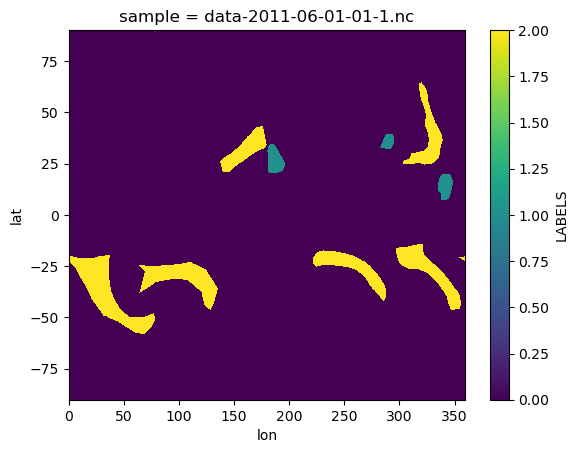

In [12]:
cgnet_test_labels.isel(sample=0).plot();

## Read in underlying data

In [13]:
%%time
cgnet_test_data = xr.open_mfdataset(test_files, drop_variables='LABELS')
cgnet_test_data

CPU times: user 940 ms, sys: 157 ms, total: 1.1 s
Wall time: 1.12 s


<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 31)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-01-...
Data variables: (12/16)
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    UBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    VBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    QREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ...       ...
    PRECT    (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    TS       (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    TREFHT   (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z1000    (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    Z200     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>
    ZBOT     (time, lat, lon) float32 dask.array<chunksize=(1, 768, 1152), meta=np.ndarray>

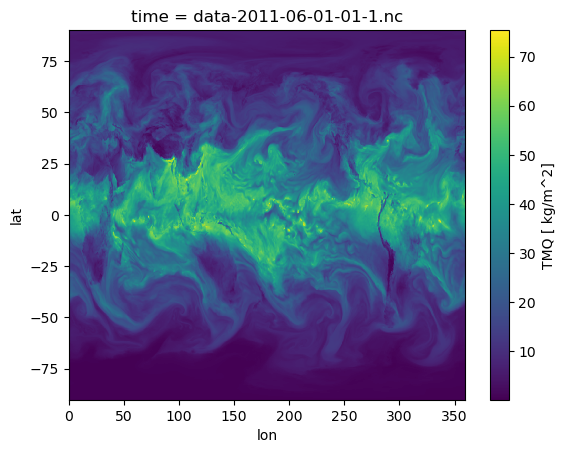

In [14]:
cgnet_test_data.TMQ.isel(time=0).plot();

In [22]:
print(cgnet_test_data.TMQ.min().values, cgnet_test_data.TMQ.max().values)

0.047127426 91.37271


## Read in predictions

In [15]:
eval_data = "test_masks.040523.nc"
cgnet_eval_data = xr.open_mfdataset(cgnet_eval_filepath+eval_data)
cgnet_eval_data

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 61)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-01-...
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(61, 768, 1152), meta=np.ndarray>

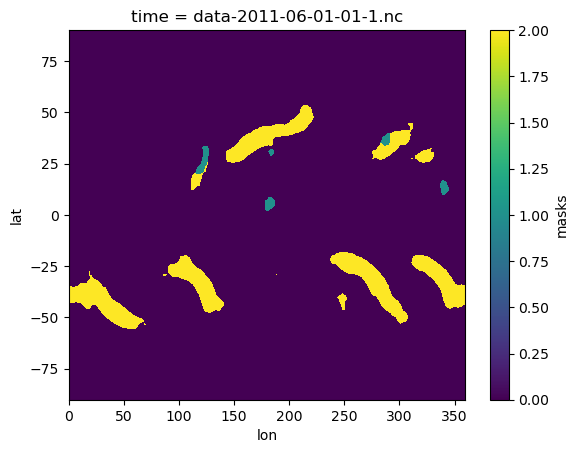

In [17]:
cgnet_eval_data.masks.isel(time=0).plot();

## Compare predictions and labels

In [18]:
# set number of files to sample
num = 5

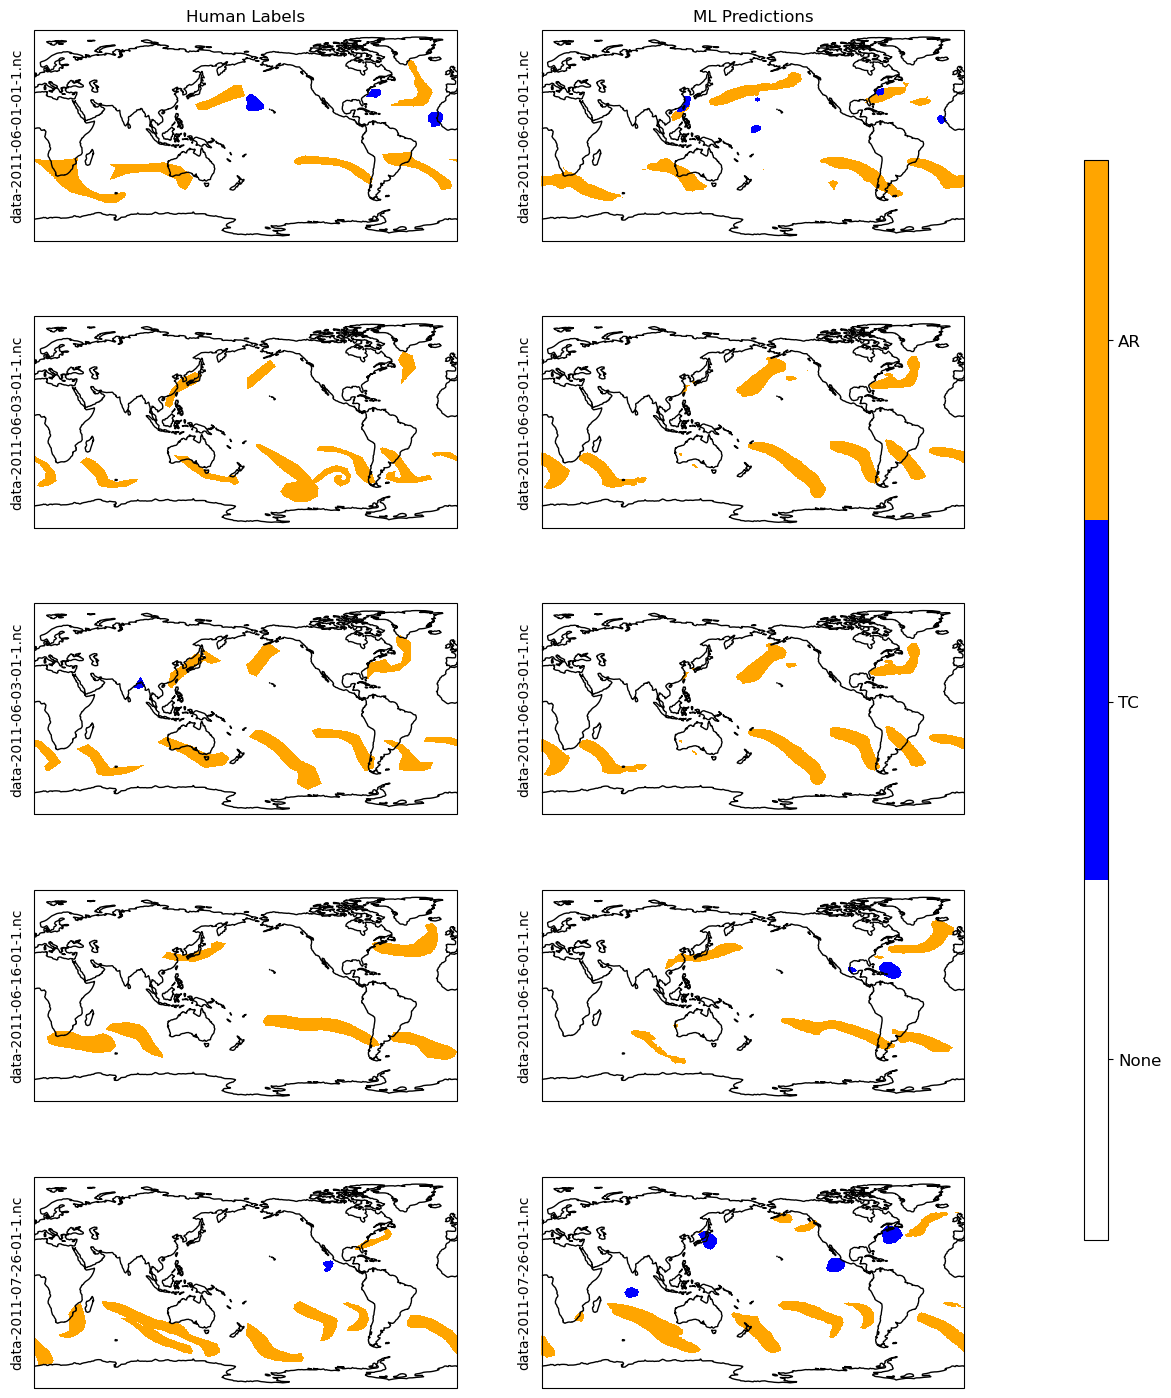

In [19]:
# figure settings
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
fig, axs = plt.subplots(num, 2, figsize=(12,18), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

for m in range(len(test_files[:num])):  
    
    # labels
    lat = cgnet_test_labels.lat
    lon = cgnet_test_labels.lon
    axs[m,0].pcolormesh(lon, lat, cgnet_test_labels.isel(sample=m), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) 
    axs[m,0].coastlines()
    if m==0:
        axs[m,0].set_title('Human Labels')
    axs[m,0].set_yticks([])
    axs[m,0].set_ylabel(str(cgnet_test_labels.isel(sample=m).sample.values))


    # predictions
    lat = cgnet_eval_data.lat
    lon = cgnet_eval_data.lon
    axs[m,1].pcolormesh(lon, lat, cgnet_eval_data.masks.isel(time=m), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) 
    axs[m,1].coastlines()
    if m==0:
        axs[m,1].set_title('ML Predictions')
    axs[m,1].set_yticks([])
    axs[m,1].set_ylabel(str(cgnet_eval_data.isel(time=m).time.values))
    
# colorbar
cbar_ax = fig.add_axes([1, 0.2, 0.02, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#plt.savefig('../figures/toSCP/evaluate_040523_5maps.png', bbox_inches='tight')

## Add underlying data to comparison
## TO DO: index the underlying fields differently since they don't repeat
Switch to indexing by exact time?

In [32]:
num = 5

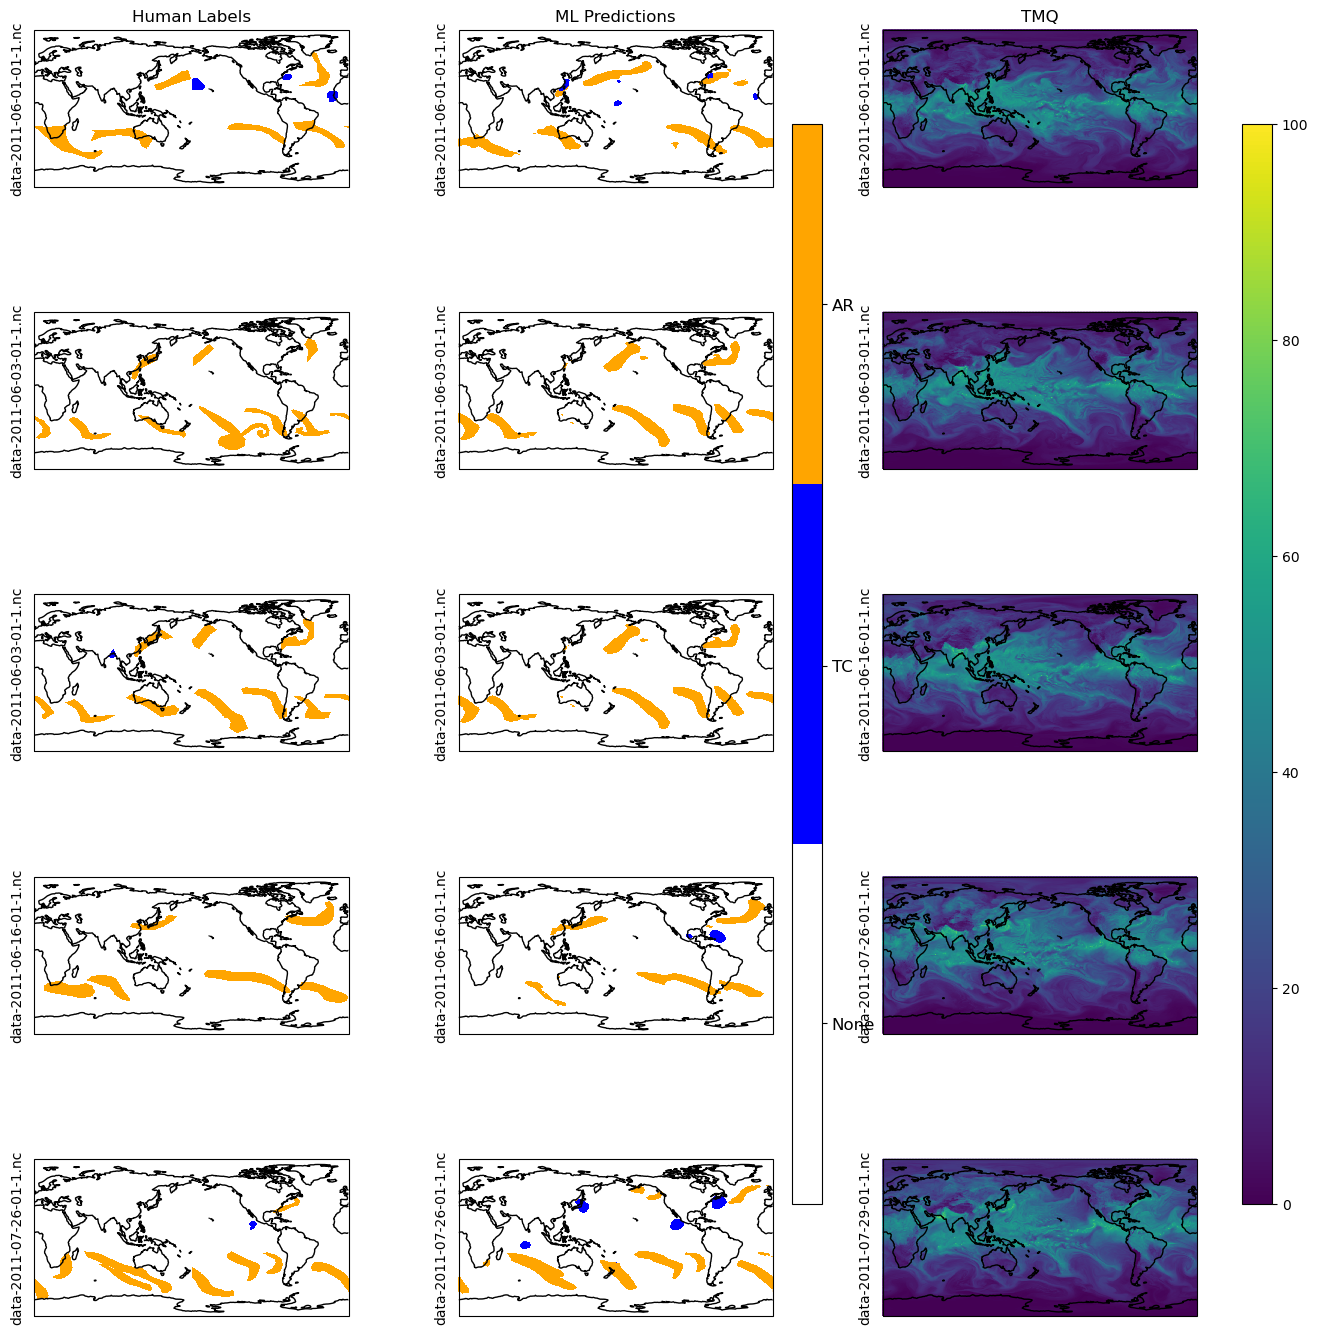

In [33]:
# figure settings
cmap_all = mcolors.ListedColormap(['w', 'blue', 'orange'])
bounds = [0, 0.99, 1.99, 2.99]
fig, axs = plt.subplots(num, 3, figsize=(15,18), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

for m in range(len(test_files[:num])):  
    
    # labels
    lat = cgnet_test_labels.lat
    lon = cgnet_test_labels.lon
    axs[m,0].pcolormesh(lon, lat, cgnet_test_labels.isel(sample=m), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) 
    axs[m,0].coastlines()
    if m==0:
        axs[m,0].set_title('Human Labels')
    axs[m,0].set_yticks([])
    axs[m,0].set_ylabel(str(cgnet_test_labels.isel(sample=m).sample.values))


    # predictions
    lat = cgnet_eval_data.lat
    lon = cgnet_eval_data.lon
    axs[m,1].pcolormesh(lon, lat, cgnet_eval_data.masks.isel(time=m), cmap=cmap_all, vmin=0, vmax=2.99, transform=ccrs.PlateCarree()) 
    axs[m,1].coastlines()
    if m==0:
        axs[m,1].set_title('ML Predictions')
    axs[m,1].set_yticks([])
    axs[m,1].set_ylabel(str(cgnet_eval_data.isel(time=m).time.values))
    
    # data - TMQ
    lat = cgnet_test_data.lat
    lon = cgnet_test_data.lon
    axs[m,2].pcolormesh(lon, lat, cgnet_test_data.TMQ.isel(time=m), cmap='viridis', vmin=0, vmax=100, transform=ccrs.PlateCarree())
    axs[m,2].coastlines()
    if m==0:
        axs[m,2].set_title('TMQ')
    axs[m,2].set_yticks([])
    axs[m,2].set_ylabel(str(cgnet_test_data.isel(time=m).time.values))
    
# colorbar masks
cb1_ax = fig.add_axes([0.63, 0.2, 0.02, 0.6])
norm1 = mpl.colors.Normalize(vmin=0, vmax=2.99)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, 
                                cmap=cmap_all,
                                norm=norm1,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99])
loc    = labels + .5
tick_1 = ['None','TC','AR']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)
                        
# colorbar TMQ
cb2_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
norm2 = mpl.colors.Normalize(vmin=0, vmax=100)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, 
                                cmap='viridis',
                                norm=norm2,
                                orientation='vertical')

plt.subplots_adjust(wspace=0.35, hspace=0.1)
#plt.savefig('../figures/toSCP/evaluate_040523_5maps_TMQ.png', bbox_inches='tight')